In [10]:
import numpy as np
import networkx as nx
import math
import random

import tqdm

import matplotlib.pyplot as plt

In [8]:
def aging_barabasi_albert_graph(N,alpha,m=2,m0=2):
    """
    Implements the modified barabasi-albert model given
    in the paper titled "Self-organized Criticality in an 
    Integrate-and-Fire Neuron Model Based on Modified Aging Networks".
    
    Each time step a random node is chosen based on its age to generate
    a new node linked to it, which also links to its (m-1) nearest neighbors
    with a probability given by the standard barabasi-albert model.
    
    N: int
        Network size
    alpha: float
        Age factor which influences probabilities based on age
    m: int
        Number of links for each new node
    m0: int
        Initial size of the network
    """
    
    # Initialize fully connected graph with m0 nodes
    graph = nx.complete_graph(m0)
    
    age = np.ones(N)
    for n in range(m0,N):
        # Get degrees for all current nodes in array form
        degrees = np.array(list(graph.degree(np.arange(n)).values()))
        
        # Calculate pmf for a node to generate new node
        i_probs = degrees / age[:n]**(alpha)
        i_probs /= np.sum(i_probs)
        
        # Choose a random node i
        i = np.random.choice(np.arange(n),p=i_probs)
        
        # neighbors j of i
        neighbors = np.array(graph.neighbors(i))
        
        # Calculate pmf for linked nearest neighbors of i
        j_probs = degrees[neighbors] / np.sum(degrees[neighbors])
        
        # Choose a random node i
        j = list(np.random.choice(neighbors,size=(m-1),replace=False,p=j_probs))
        
        # Add node to network with chosen edges
        graph.add_edges_from(zip([n]*m,[i] + j))
        
        # Advance the time and apply to age of nodes
        age[:n] += 1
    
    return graph

In [18]:
def create_if_network(num_nodes,num_edges=10,p=0.5,alpha=1,net_type="full"):
    if net_type == 'random':
        graph = nx.gnp_random_graph(num_nodes,p)
    elif net_type == 'ws':
        graph = nx.watts_strogatz_graph(num_nodes, num_edges, p)
    elif net_type == 'ba':
        graph = nx.barabasi_albert_graph(num_nodes, num_edges)
    elif net_type == 'aging':
        graph = aging_barabasi_albert_graph(num_nodes,alpha,m=num_edges,m0=num_edges)
    elif net_type == 'full':
        graph = nx.complete_graph(num_nodes)
        
    return graph

class simple_integrate_and_fire_model:
    """
    Implements a simplified version of the integrate and fire
    model described in https://arxiv.org/pdf/0712.1003.pdf using
    separated time-scales where the driving rate is much slower
    than the relaxation rate. This makes a rule-based algorithm with
    a driving step followed by a relaxation step where an avalanche
    is allowed to complete before the next drive step, much like
    the BTW sandpile model.
    
    For the sake of simplicity the leak terms and dynamic synapses
    are left out due to the smaller time scales at which they are influential.
    
    The model does include the possibility of inhibitory neurons or synapses.
    """
    
    def __init__(self,network,v_ext=0.025,v_th=1,u=0.2,J=4,p_inh=0.0,inh_type="neuron"):
        # Set parameters
        self.network = network
        self.v_ext = v_ext
        self.v_th = v_th
        self.u = u
        self.J = J
        
        # Initialize weight matrix from network
        self.w = nx.adjacency_matrix(network)
        
        # Link indices in weight matrix
        self.link_idx = (self.w != 0)
        
        # Network size
        self.N = self.w.shape[0]
        
        # Determine synapse types
        self.synapse_types = self.w.astype(int)
        
        # Inhibition determined per synapse
        if inh_type == "synapse":
            n_inh = int(p_inh * self.synapse_types.size)

            type_vals = np.ones(self.synapse_types.size)
            if n_inh > 0:
                inhibitory = np.random.choice(np.arange(self.synapse_types.size),size=n_inh,replace=False)
                type_vals[inhibitory] = -1

            self.synapse_types[self.link_idx] = type_vals
        
        # Inhibition determined per neuron
        elif inh_type == "neuron":
            n_inh = int(p_inh * self.N)
            
            if n_inh > 0:
                inhibitory = np.random.choice(np.arange(self.N),size=n_inh,replace=False)
                self.synapse_types[:,inhibitory] *= -1
        
        # Retrieve J_ij (given as w) from w
        self.w = J * self.w
        
        # Initialize membrane potentials randomly
        self.v = np.random.uniform(0,self.v_th,self.w.shape[0])
        
        # Statistics
        self.avalanche_size = np.array([],dtype=int)
        
    def simulate(self,steps):
        avalanche_size = np.zeros(steps,dtype=int)
        
        with tqdm.tqdm(total=steps) as pbar:
            for t in range(steps):
                # Drive step
                i = np.random.randint(self.v.size)
                self.v[i] += self.v_ext

                # Initialize check list
                check_nodes = [i]

                # Relaxation step
                s = 0
                while len(check_nodes) > 0:
                    i = check_nodes.pop(0)

                    if self.v[i] > self.v_th:
                        # number of neighbors of i
                        n = np.sum(self.w[:,i].size)

                        # neighbor indices
                        j = self.w[:,i].nonzero()[0]

                        # Spiking results in firing potential to neighbors
                        self.v[j] += self.synapse_types[j,i].toarray().flatten() * \
                                     self.u*self.w[j,i].toarray().flatten() / n

                        # Add neighbors to check list
                        check_nodes += [elem for elem in list(j) if elem not in check_nodes]

                        # Subtract threshold potential after spike
                        self.v[i] -= self.v_th

                        # Increase current avalanche size
                        s += 1

                # Enforce minimum potential of zero
                self.v[self.v < 0] = 0
                        
                avalanche_size[t] = s
                
                pbar.update()
            
        self.avalanche_size = np.concatenate((self.avalanche_size,avalanche_size))
        
    def reset_avalanche_stats(self):
        self.avalanche_size = np.array([],dtype=int)
        
    def avalanche_size_pdf(self):
        pdf = np.bincount(self.avalanche_size) / self.avalanche_size.size
        
        nonzeros = (pdf != 0)
        indices = np.arange(nonzeros.size)[nonzeros]
        
        return indices,pdf[nonzeros]

class LHG_integrate_and_fire_model:
    """
    Implements the leaky integrate and fire model described in 
    https://ediss.uni-goettingen.de/bitstream/handle/11858/00-1735-0000-0006-B3B3-B/levina.pdf?sequence=1.
    
    The algorithm allows for leak terms, dynamic synapses and inhibition.
    
    The model operates on the assumption of separated time scales. Meaning that a neuronal
    avalanche is allowed to complete long before the next external input is applied. This
    means that the system is slowly driven and reacts quickly to any perturbation. The
    discretization is done by setting the driving rate to 1 and setting the time step
    size equal to the driving rate. The relaxation is assumed to be fast enough to 
    happen instantly after the driving step and to finish at around the same time (t + dt ~ t). 
    This is done due to the event driven nature of the system dynamics.
    
    Leakage and synapse recovery are both applied using the values at the start 
    of the time step for the time integration.
    
    Inhibition is implemented in two possible ways: 
    (1) Ignoring Dale's principle and taking a percentage of the 
    synapses to be inhibitory or (2) obeying Dale's principle and
    taking a percentage of the neurons to be inhibitory.
    
    TODO:
    - Implement leak terms - done (Levina claims: no relevant dynamics changes)
    - Implement dynamic synapses - done
    - Implement inhibitory neurons - done (Levina claims: no relevant dynamics changes)
    """
    
    def __init__(self,network,v_ext=0.025,v_th=1,u=0.2,a=0.5,
                 nu=10,tl=40,C=0.98,leakage=False,p_inh=0.0,inh_type="neuron"):
        """
        network: networkx network object
            Network used for the simulation
        v_ext: float
            External input added to the potential 
            of a neuron during the driving step
        v_th: float
            Membrane potential treshold
        u: float
            Transmitter resource usage / 
            saturation constant of synaptic strength
        
        Dynamic synapse parameters:
            a: float
                Maximum connection strength parameter (a / u = J_max)
            nu: float
                Synaptic recovery time scale parameter
        
        Leak term parameters:
            tl: float
                Rate of leakage from a node
            C: float
                Compensatory synaptic current
            leakage: bool
                Determine if leakage occurs
                
        p_inh: float
            Percentage of inhibitory synapses
        inh_type: string ("neuron" or "synapse")
            Type of inhibition: per synapse (ignoring Dale's principle)
            or per neuron (obeying Dale's principle)
        """
        
        # Set parameters
        self.network = network
        self.v_ext = v_ext
        self.v_th = v_th
        self.u = u
        self.a = a
        self.nu = nu
        self.tl = tl
        self.C = C
        self.leakage = leakage
        
        # Retrieve J_ij (weight matrix w) from network
        self.w = nx.adjacency_matrix(network)
        
        # Link indices in weight matrix
        self.link_idx = (self.w != 0)
        
        # Network size
        self.N = self.w.shape[0]
        
        # Determine synapse types
        self.synapse_types = self.w.astype(int)
        
        # Inhibition determined per synapse
        if inh_type == "synapse":
            n_inh = int(p_inh * self.synapse_types.size)

            type_vals = np.ones(self.synapse_types.size)
            if n_inh > 0:
                inhibitory = np.random.choice(np.arange(self.synapse_types.size),size=n_inh,replace=False)
                type_vals[inhibitory] = -1

            self.synapse_types[self.link_idx] = type_vals
        
        # Inhibition determined per neuron
        elif inh_type == "neuron":
            n_inh = int(p_inh * self.N)
            
            if n_inh > 0:
                inhibitory = np.random.choice(np.arange(self.N),size=n_inh,replace=False)
                self.synapse_types[:,inhibitory] *= -1
        
        # Randomize synaptic connection strengths
        self.w = self.w.astype(float)
        self.w[self.link_idx] = np.random.uniform(0,self.a/self.u,self.link_idx.size)
        
        # Synaptic recovery time-scale
        self.tj = self.nu * self.N
        
        # Initialize membrane potentials randomly
        self.v = np.random.uniform(0,self.v_th,self.N)
        
        # Statistics
        self.avalanche_size = np.array([],dtype=int)
        
    def simulate(self,steps):
        # Analytics to be collected
        avalanche_size = np.zeros(steps,dtype=int)
        
        weights = []
        
        with tqdm.tqdm(total=steps) as pbar:
            for t in range(steps):
                
                weights.append(self.w)
                
                # Apply leakage terms
                if self.leakage:
                    self.v += self.C - self.v / self.tl
                
                # Drive step
                i = np.random.randint(self.v.size)
                self.v[i] += self.v_ext

                # Synaptic recovery term
                J_rec = (self.a / self.u - self.w[self.link_idx]) / self.tj
                
                # Initialize check list
                check_nodes = [i]

                # Relaxation step
                s = 0
                while len(check_nodes) > 0:
                    i = check_nodes.pop(0)

                    if self.v[i] > self.v_th:
                        # number of neighbors of i
                        n = np.sum(self.w[:,i].size)

                        # neighbor indices
                        j = self.w[:,i].nonzero()[0]

                        # Spiking results in firing potential to neighbors
                        # Inhibitory neurons subtract potential instead of adding
                        self.v[j] += self.synapse_types[j,i].toarray().flatten() * \
                                     self.u * self.w[j,i].toarray().flatten() / n
                        
                        # Decrease synaptic connection strength
                        self.w[j,i] -= self.u*self.w[j,i]
                        
                        # Add neighbors to check list
                        check_nodes += [elem for elem in list(j) if elem not in check_nodes]

                        # Subtract threshold potential after spike
                        self.v[i] -= self.v_th

                        # Increase current avalanche size
                        s += 1

                # Enforce minimum potential of zero
                self.v[self.v < 0] = 0
                
                # Apply synaptic recovery after relaxation
                self.w[self.link_idx] += J_rec
                
                avalanche_size[t] = s 
                
                pbar.update()
            
            
        self.avalanche_size = np.concatenate((self.avalanche_size,avalanche_size))
        
    def reset_avalanche_stats(self):
        self.avalanche_size = np.array([],dtype=int)
        
    def avalanche_size_pdf(self):
        pdf = np.bincount(self.avalanche_size) / self.avalanche_size.size
        
        nonzeros = (pdf != 0)
        indices = np.arange(nonzeros.size)[nonzeros]
        
        return indices,pdf[nonzeros]

In [6]:
def del_rand(adj_mat, neg_nod, per, mode):
## Function that deletes percentage of nodes or links randomly
## Attention: neg_nodes is not used in the IF model

    am = adj_mat.copy()
    nn = neg_nod.copy()
    
    if mode == 'node':
        
        nodes = math.ceil(adj_mat.shape[0]*per/100)
        
        for i in range(0,nodes-1):
        
            n = random.randint(0, adj_mat.shape[0]-1)
            am[n,:] = 0
            am[:, n] = 0
        
            nn = [nn != n]
    
    else:
        
        links = math.ceil(adj_mat.shape[0]*per/100)
        
        for i in range(0,links-1):
            
            l1 = random.randint(0, adj_mat.shape[0]-1)
            l2 = random.randint(0, adj_mat.shape[0]-1)
            am[l1,l2] = 0
        
    
    return am, nn

## Aging

In [16]:
network = create_if_network(50,net_type="aging")

model = LHG_integrate_and_fire_model(network,a=0.95)

model.simulate(100000)

model.reset_avalanche_stats()

model.simulate(100000)

100%|██████████| 10000/10000 [04:23<00:00, 38.00it/s]


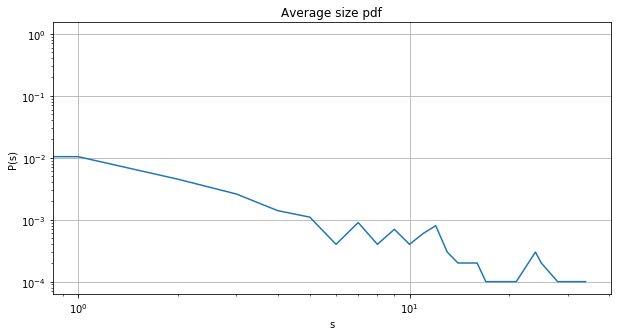

In [17]:
plt.figure(figsize=(10,5))
plt.title("Average size pdf")
plt.ylabel("P(s)")
plt.xlabel("s")

indices, pdf = model.avalanche_size_pdf()

plt.plot(indices, pdf)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

In [11]:
#Delete 5 percentages of nodes
am5, _ = del_rand(nx.adjacency_matrix(model.network), _, 5, 'node')
am10, _ = del_rand(nx.adjacency_matrix(model.network), _, 10, 'node')
am20, _ = del_rand(nx.adjacency_matrix(model.network), _, 20, 'node')
am40, _ = del_rand(nx.adjacency_matrix(model.network), _, 40, 'node')
am60, _ = del_rand(nx.adjacency_matrix(model.network), _, 60, 'node')

C:\Users\John\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [19]:
#Replace adj matrix with the one that has 80% of the initial nodes
network.adjacency_matrix = am20

#Rerun the model as before
model20 = LHG_integrate_and_fire_model(network,a=0.95)

model20.simulate(100000)

model20.reset_avalanche_stats()

model20.simulate(100000)

#Replace adj matrix with the one that has 60% of the initial nodes
network.adjacency_matrix = am40

model40 = LHG_integrate_and_fire_model(network,a=0.95)

model40.simulate(100000)

model40.reset_avalanche_stats()

model40.simulate(100000)

100%|██████████| 10000/10000 [04:55<00:00, 33.81it/s]


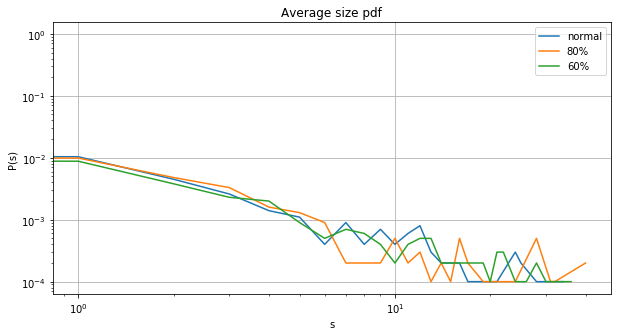

In [21]:
plt.figure(figsize=(10,5))
plt.title("Average size pdf")
plt.ylabel("P(s)")
plt.xlabel("s")

indices20, pdf20 = model20.avalanche_size_pdf()
indices40, pdf40 = model40.avalanche_size_pdf()

plt.plot(indices, pdf, indices20, pdf20, indices40, pdf40)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend(['normal', '80%', '60%'])
plt.show()

## Barabasi

In [ ]:
network = create_if_network(50,net_type="ba")

model = LHG_integrate_and_fire_model(network,a=0.95)

model.simulate(100000)

model.reset_avalanche_stats()

model.simulate(100000)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Average size pdf")
plt.ylabel("P(s)")
plt.xlabel("s")

indices, pdf = model.avalanche_size_pdf()

plt.plot(indices, pdf)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

In [ ]:
#Delete 5 percentages of nodes
am5, _ = del_rand(nx.adjacency_matrix(model.network), _, 5, 'node')
am10, _ = del_rand(nx.adjacency_matrix(model.network), _, 10, 'node')
am20, _ = del_rand(nx.adjacency_matrix(model.network), _, 20, 'node')
am40, _ = del_rand(nx.adjacency_matrix(model.network), _, 40, 'node')
am60, _ = del_rand(nx.adjacency_matrix(model.network), _, 60, 'node')

In [ ]:
#Replace adj matrix with the one that has 80% of the initial nodes
network.adjacency_matrix = am20

#Rerun the model as before
model20 = LHG_integrate_and_fire_model(network,a=0.95)

model20.simulate(100000)

model20.reset_avalanche_stats()

model20.simulate(100000)

#Replace adj matrix with the one that has 60% of the initial nodes
network.adjacency_matrix = am40

model40 = LHG_integrate_and_fire_model(network,a=0.95)

model40.simulate(100000)

model40.reset_avalanche_stats()

model40.simulate(100000)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Average size pdf")
plt.ylabel("P(s)")
plt.xlabel("s")

indices20, pdf20 = model20.avalanche_size_pdf()
indices40, pdf40 = model40.avalanche_size_pdf()

plt.plot(indices, pdf, indices20, pdf20, indices40, pdf40)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend(['normal', '80%', '60%'])
plt.show()

## Small World

In [ ]:
network = create_if_network(50,net_type="ws")

model = LHG_integrate_and_fire_model(network,a=0.95)

model.simulate(100000)

model.reset_avalanche_stats()

model.simulate(100000)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Average size pdf")
plt.ylabel("P(s)")
plt.xlabel("s")

indices, pdf = model.avalanche_size_pdf()

plt.plot(indices, pdf)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

In [ ]:
#Delete 5 percentages of nodes
am5, _ = del_rand(nx.adjacency_matrix(model.network), _, 5, 'node')
am10, _ = del_rand(nx.adjacency_matrix(model.network), _, 10, 'node')
am20, _ = del_rand(nx.adjacency_matrix(model.network), _, 20, 'node')
am40, _ = del_rand(nx.adjacency_matrix(model.network), _, 40, 'node')
am60, _ = del_rand(nx.adjacency_matrix(model.network), _, 60, 'node')

In [ ]:
#Replace adj matrix with the one that has 80% of the initial nodes
network.adjacency_matrix = am20

#Rerun the model as before
model20 = LHG_integrate_and_fire_model(network,a=0.95)

model20.simulate(100000)

model20.reset_avalanche_stats()

model20.simulate(100000)

#Replace adj matrix with the one that has 60% of the initial nodes
network.adjacency_matrix = am40

model40 = LHG_integrate_and_fire_model(network,a=0.95)

model40.simulate(100000)

model40.reset_avalanche_stats()

model40.simulate(100000)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Average size pdf")
plt.ylabel("P(s)")
plt.xlabel("s")

indices20, pdf20 = model20.avalanche_size_pdf()
indices40, pdf40 = model40.avalanche_size_pdf()

plt.plot(indices, pdf, indices20, pdf20, indices40, pdf40)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend(['normal', '80%', '60%'])
plt.show()

## Random

In [ ]:
network = create_if_network(50,net_type="random")

model = LHG_integrate_and_fire_model(network,a=0.95)

model.simulate(100000)

model.reset_avalanche_stats()

model.simulate(100000)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Average size pdf")
plt.ylabel("P(s)")
plt.xlabel("s")

indices, pdf = model.avalanche_size_pdf()

plt.plot(indices, pdf)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

In [ ]:
#Delete 5 percentages of nodes
am5, _ = del_rand(nx.adjacency_matrix(model.network), _, 5, 'node')
am10, _ = del_rand(nx.adjacency_matrix(model.network), _, 10, 'node')
am20, _ = del_rand(nx.adjacency_matrix(model.network), _, 20, 'node')
am40, _ = del_rand(nx.adjacency_matrix(model.network), _, 40, 'node')
am60, _ = del_rand(nx.adjacency_matrix(model.network), _, 60, 'node')

In [ ]:
#Replace adj matrix with the one that has 80% of the initial nodes
network.adjacency_matrix = am20

#Rerun the model as before
model20 = LHG_integrate_and_fire_model(network,a=0.95)

model20.simulate(100000)

model20.reset_avalanche_stats()

model20.simulate(100000)

#Replace adj matrix with the one that has 60% of the initial nodes
network.adjacency_matrix = am40

model40 = LHG_integrate_and_fire_model(network,a=0.95)

model40.simulate(100000)

model40.reset_avalanche_stats()

model40.simulate(100000)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Average size pdf")
plt.ylabel("P(s)")
plt.xlabel("s")

indices20, pdf20 = model20.avalanche_size_pdf()
indices40, pdf40 = model40.avalanche_size_pdf()

plt.plot(indices, pdf, indices20, pdf20, indices40, pdf40)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend(['normal', '80%', '60%'])
plt.show()

## Fully Connected

In [ ]:
network = create_if_network(50,net_type="random")

model = LHG_integrate_and_fire_model(network,a=0.95)

model.simulate(100000)

model.reset_avalanche_stats()

model.simulate(100000)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Average size pdf")
plt.ylabel("P(s)")
plt.xlabel("s")

indices, pdf = model.avalanche_size_pdf()

plt.plot(indices, pdf)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

In [ ]:
#Delete 5 percentages of nodes
am5, _ = del_rand(nx.adjacency_matrix(model.network), _, 5, 'node')
am10, _ = del_rand(nx.adjacency_matrix(model.network), _, 10, 'node')
am20, _ = del_rand(nx.adjacency_matrix(model.network), _, 20, 'node')
am40, _ = del_rand(nx.adjacency_matrix(model.network), _, 40, 'node')
am60, _ = del_rand(nx.adjacency_matrix(model.network), _, 60, 'node')

In [ ]:
#Replace adj matrix with the one that has 80% of the initial nodes
network.adjacency_matrix = am20

#Rerun the model as before
model20 = LHG_integrate_and_fire_model(network,a=0.95)

model20.simulate(100000)

model20.reset_avalanche_stats()

model20.simulate(100000)

#Replace adj matrix with the one that has 60% of the initial nodes
network.adjacency_matrix = am40

model40 = LHG_integrate_and_fire_model(network,a=0.95)

model40.simulate(100000)

model40.reset_avalanche_stats()

model40.simulate(100000)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Average size pdf")
plt.ylabel("P(s)")
plt.xlabel("s")

indices20, pdf20 = model20.avalanche_size_pdf()
indices40, pdf40 = model40.avalanche_size_pdf()

plt.plot(indices, pdf, indices20, pdf20, indices40, pdf40)
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend(['normal', '80%', '60%'])
plt.show()